In [2]:
# basic
import math
import warnings
import numpy as np 
import pandas as pd 
import datetime as dt 
from pandas_datareader import data as pdr 
warnings.filterwarnings("ignore")

# statsmodel.api 
import statsmodels.api as sm 
from statsmodels import stats

# matplotlib
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates

# (一.) Violations of Regression Models

When using a regression to fit a model to our data, the assumptions of regression analysis must be satisfied in order to ensure good parameter estimates and accurate fit statistics. We would like parameters to be:

unbiased (expected value over different samples is the true value)

consistent (converging to the true value with many samples)

efficient (minimized variance)


--> Focus on the Residuals

Once you have your residuals you can perform many statistical tests.

If your residuals do not follow a given distribution (usually normal, but depends on your model), 

then you know that something is wrong and you should be concerned with the accuracy of your predictions.

--> Here we gona use statsmodel( jarque_bera  to test the normality of the residual distribution )

In [3]:
residuals = np.random.normal(0, 1, 100)

# Testing Residual For Normal Distribution
_, pvalue, _, _ = sm.stats.stattools.jarque_bera(residuals)
print ("Nomral Distriuted Residual : ",pvalue)

# Generate residual with Poisson Distribution
residuals = np.random.poisson(size = 100)

# Testing Residual For Poisson Distribution
_, pvalue, _, _ = sm.stats.stattools.jarque_bera(residuals)
print("Poisson Distriuted Residual : ",pvalue)

Nomral Distriuted Residual :  0.2992650381372925
Poisson Distriuted Residual :  2.2091568455895914e-08


 #Heteroskedasticity

Heteroskedasticity means that the variance of the error terms is not constant across observations. Intuitively, this means that the observations are not uniformly distributed along the regression line. It often occurs in cross-sectional data where the differences in the samples we are measuring lead to differences in the variance.

Text(0, 0.5, 'Y')

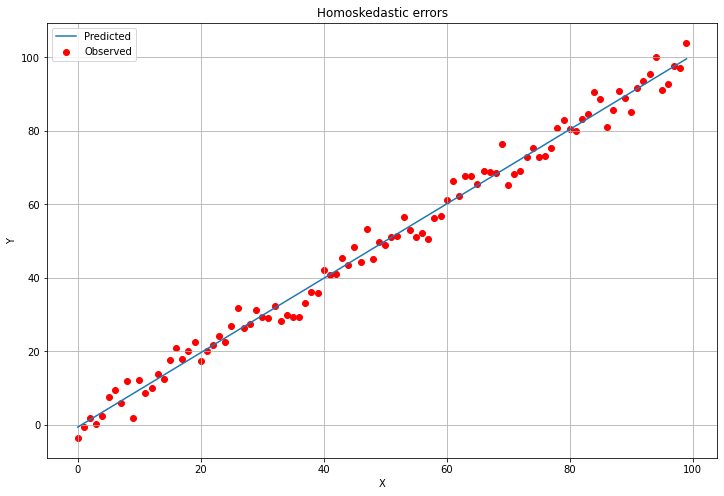

In [4]:
# Artificially create dataset with constant variance around a line
xs = np.arange(100)
y1 = xs + 3*np.random.randn(100)

# Get results of linear regression
slr1 = sm.OLS(y1, sm.add_constant(xs)).fit()

# Construct the fit line
fit1 = slr1.params[0] + slr1.params[1]*xs

# Plot data and regression line
figf,ax = plt.subplots(figsize=(12,8))
ax.set_title('Homoskedastic errors')
ax.scatter(xs, y1,color='red')
ax.plot(xs, fit1)
plt.legend(['Predicted', 'Observed'])
plt.grid()
plt.xlabel('X')
plt.ylabel('Y')

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.557
Method:                 Least Squares   F-statistic:                     125.3
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           3.17e-19
Time:                        14:15:40   Log-Likelihood:                -478.43
No. Observations:                 100   AIC:                             960.9
Df Residuals:                      98   BIC:                             966.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.6533      5.804     -0.802      0.425     -16.171       6.864
x1             1.1338      0.101     11.194      0.000       0.933       1.335
==============================================================================
Omnibus:                       16.084   Durbin-Watson:                   2.303
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               48.039
Skew:                          -0.401   Prob(JB):                     3.70e-11
Kurtosis:                       6.299   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

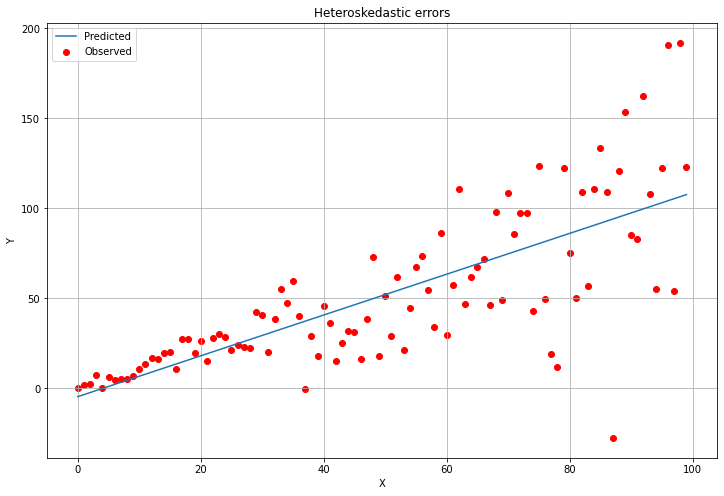

In [5]:
y2 = xs*(1 + .5*np.random.randn(100))

# Perform linear regression
slr2 = sm.OLS(y2, sm.add_constant(xs)).fit()
fit2 = slr2.params[0] + slr2.params[1]*xs

# Plot data and regression line
fig,ax = plt.subplots(figsize=(12,8))
plt.scatter(xs, y2,color='red')
plt.plot(xs, fit2)
plt.title('Heteroskedastic errors')
plt.legend(['Predicted', 'Observed'])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()

slr2.summary()

Easily point out that Above Figure Residual is not Nomral Distribution ! 

In [6]:
residuals1 = y1-fit1
residuals2 = y2-fit2

xs_with_constant = sm.add_constant(xs)

# Nomrality test for residual
_, jb_pvalue1, _, _ = sm.stats.stattools.jarque_bera(residuals1)
_, jb_pvalue2, _, _ = sm.stats.stattools.jarque_bera(residuals2)
print ( "p-value for residuals1 being normal", jb_pvalue1)
print ( "p-value for residuals2 being normal", jb_pvalue2 )

# Heteroskedasticity test for residual 
_, pvalue1, _, _ = stats.diagnostic.het_breuschpagan(residuals1, xs_with_constant)  
_, pvalue2, _, _ = stats.diagnostic.het_breuschpagan(residuals2, xs_with_constant)  

print ( "p-value for residuals1 being heteroskedastic", pvalue1 )
print ( "p-value for residuals2 being heteroskedastic", pvalue2 )

p-value for residuals1 being normal 0.6392194240181713
p-value for residuals2 being normal 3.7026774007528364e-11
p-value for residuals1 being heteroskedastic 0.4530873787871764
p-value for residuals2 being heteroskedastic 8.859264807951442e-06


# correcting for Heteroskedasticity

How does heteroskedasticity affect our analysis? 

The problematic situation, known as conditional heteroskedasticity, 

is when the error variance is correlated with the independent variables as it is above. T

his makes the F-test for regression significance and t-tests for the significances of individual coefficients unreliable.

Most often this results in overestimation of the significance of the fit.

The Breusch-Pagan test and the White test can be used to detect conditional heteroskedasticity. 

If we suspect that this effect is present, we can alter our model to try and correct for it. 

One method is generalized least squares(GLSE) , which requires a manual alteration of the original equation. 

Another is computing robust standard errors, which corrects the fit statistics to account for the heteroskedasticity. 

statsmodels can compute robust standard errors; note the difference in the statistics below.

# Serial correlation of errors (Price Data , Seanson Sell) 

A common and serious problem is when errors are correlated across observations (known serial correlation or autocorrelation). 

This can occur, for instance, when some of the data points are related, or when we use time-series data with periodic fluctuations. 

If one of the independent variables depends on previous values of the dependent variable - such as when it is equal to the value of the dependent variable in the previous period

 - or if incorrect model specification leads to autocorrelation, then the coefficient estimates will be inconsistent and therefore invalid. 
 
Otherwise, the parameter estimates will be valid, but the fit statistics will be off. 
 
For instance, if the correlation is positive, we will have inflated F- and t-statistics, leading us to overestimate the significance of the model.

If the errors are homoskedastic, 

we can test for autocorrelation using the Durbin-Watson test, 

which is conveniently reported in the regression summary in statsmodels.

# correcting --> Times Series Model --> AR(1) ,GARCH(1,1) , GJR-MA ,....etc

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    DAL   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.663
Method:                 Least Squares   F-statistic:                     497.8
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.65e-61
Time:                        14:15:42   Log-Likelihood:                -612.81
No. Observations:                 253   AIC:                             1230.
Df Residuals:                     251   BIC:                             1237.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.9491      0.343     90.164      0.000      30.273      31.625
x1             0.0526      0.002     22.311      0.000       0.048       0.057
==============================================================================
Omnibus:                       30.380   Durbin-Watson:                   0.085
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               44.233
Skew:                          -0.748   Prob(JB):                     2.48e-10
Kurtosis:                       4.398   Cond. No.                         290.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

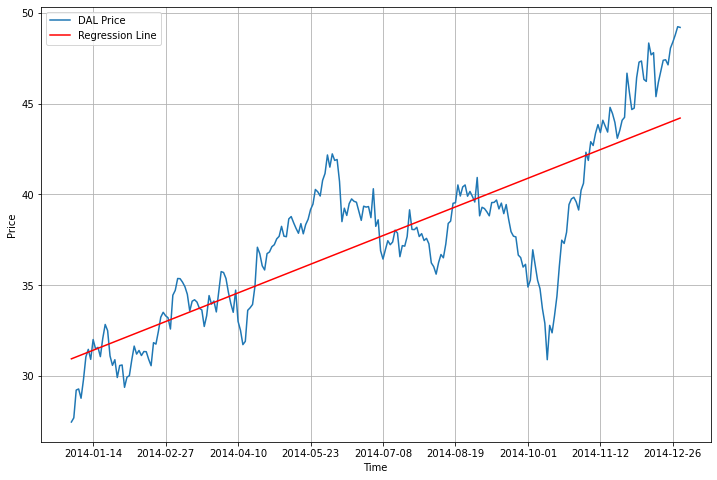

In [7]:
class Company_Data():
    """
    ticker     --> list (str)
    start ,end --> datetime 
    peirods    --> string
    """
    def __init__(self,tickers,start,end,periods):

        self.start   = start 
        self.end     = end 
        self.tickers = tickers
        self.periods = periods
    
    def get_data(self,ticker):

        self.df = pdr.get_data_yahoo(ticker,self.start,self.end).reset_index()
   
        return self.df 
    
    def Address_Date(self,date):
        
        date = str(date)
        return date[:10]
        
    def get_price_data(self):

        for i , ticker in enumerate(self.tickers) : 
            
            if i == 0 :
                Price_DF = self.get_data(ticker)
                Price_DF = Price_DF[['Date','Close']]
                Price_DF.columns = ['Date',str(ticker)]
            else:
                Merge_DF = self.get_data(ticker)[['Date','Close']]
                Merge_DF.columns = ['Date',str(ticker)]
                Price_DF = Price_DF.merge(Merge_DF,how='outer')
        
        Price_DF = Price_DF.fillna(value=0)
        Price_DF['Date'] = Price_DF.apply(lambda x : self.Address_Date(x['Date']),axis=1)
        Price_DF.index = Price_DF['Date']
        Price_DF = Price_DF.drop(['Date'],axis=1)

        return Price_DF


start   = dt.datetime(2014,1,1)
end     = dt.datetime(2015,1,1)
tickers = ["DAL"]

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()


y = Stock_DF["DAL"]
x = np.arange(len(y))

# Regress pricing data against time
model = sm.OLS(y, sm.add_constant(x)).fit()

# Construct the fit line
prediction = model.params[0] + model.params[1]*x

# Plot pricing data and regression line
plt.subplots(figsize=(12,8))
plt.plot(Stock_DF.index,Stock_DF['DAL'].values)
plt.plot(x, prediction, color='r')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))
plt.legend(['DAL Price', 'Regression Line'])
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid()

# Print summary of regression results
model.summary()

# Testing for Autocorrelation

We can test for autocorrelation in both our prices and residuals. 

We'll use the built-in method to do this, which is based on the Ljun-Box test. 

This test computes the probability that the n-th lagged datapoint is predictive of the current. 

If no max lag is given, then the function computes a max lag and returns the p-values for all lags up to that one. 

We can see here that for the 5 most recent datapoints, a significant correlation exists with the current. 

Therefore we conclude that both the data is autocorrelated.

We also test for normality for fun.

In [8]:
_, prices_qstats, prices_qstat_pvalues = sm.tsa.stattools.acf(y, qstat=True)
_, prices_qstats, prices_qstat_pvalues = sm.tsa.stattools.acf(y-prediction, qstat=True)

print ('Prices autocorrelation p-values', prices_qstat_pvalues)
print ('Residuals autocorrelation p-values', prices_qstat_pvalues)

_, jb_pvalue, _, _ = sm.stats.stattools.jarque_bera(y-prediction)

print ('Jarque-Bera p-value that residuals are normally distributed', jb_pvalue)

Prices autocorrelation p-values [5.95740213e-052 4.87274664e-096 1.02829781e-135 8.47084996e-172
 4.73269734e-204 3.41262637e-232 5.87198237e-257 7.25588001e-279
 2.79670200e-298 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000]
Residuals autocorrelation p-values [5.95740213e-052 4.87274664e-096 1.02829781e-135 8.47084996e-172
 4.73269734e-204 3.41262637e-232 5.87198237e-257 7.25588001e-279
 2.79670200e-298 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.000

# Multicollinearity

When using multiple independent variables, it is important to check for multicollinearity; 

that is, an approximate linear relation between the independent variables, such as 

$$ X_2 \approx 5 X_1 - X_3 + 4.5 $$

With multicollinearity, it is difficult to identify the independent effect of each variable, since we can change around the coefficients according to the linear relation without changing the model. 

As with truly unnecessary variables, this will usually not hurt the accuracy of the model, but will cloud our analysis. In particular, the estimated coefficients will have large standard errors. The coefficients will also no longer represent the partial effect of each variable, since with multicollinearity we cannot change one variable while holding the others constant.

High correlation between independent variables is indicative of multicollinearity. However, it is not enough, since we would want to detect correlation between one of the variables and a linear combination of the other variables. If we have high R-squared but low t-statistics on the coefficients (the fit is good but the coefficients are not estimated precisely) we may suspect multicollinearity. To resolve the problem, we can drop one of the independent variables involved in the linear relation.

For instance, using two stock indices as our independent variables is likely to lead to multicollinearity. 

Below we can see that removing one of them improves the t-statistics without hurting R-squared.


In [12]:
start   = dt.datetime(2014,1,1)
end     = dt.datetime(2015,1,1)
tickers = ["SPY","MDY","HPQ"]

# ------------ ------------ ------------ ------------ 

Company_Price = Company_Data(tickers=tickers,start=start,end=end,periods="Daily")
Stock_DF      = Company_Price.get_price_data()
Stock_DF 

,SPY,MDY,HPQ
Date,,,
2013-12-31,184.690002,244.199997,12.706630
2014-01-02,182.919998,241.399994,12.561308
2014-01-03,182.889999,242.460007,12.870118
2014-01-06,182.360001,240.929993,12.847411
2014-01-07,183.479996,242.929993,12.797457
...,...,...,...
2014-12-24,207.770004,265.899994,18.410536
2014-12-26,208.440002,266.570007,18.483196
2014-12-29,208.720001,267.809998,18.487738


In [13]:
Asset = Stock_DF['HPQ'].values 
x = Stock_DF[['SPY','MDY']]
x = sm.add_constant(x)

def OLS_Linear_Regression(y,x):

    # linear Regression
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    res   = model.fit()

    # Print Summary
    print(res.summary())

    return res.params

OLS_Linear_Regression(y=Asset,x=x)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     982.7
Date:                Sat, 28 Aug 2021   Prob (F-statistic):          3.62e-119
Time:                        14:17:14   Log-Likelihood:                -174.38
No. Observations:                 253   AIC:                             354.8
Df Residuals:                     250   BIC:                             365.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.4827      1.061    -11.763      0.0

const   -12.482731
SPY       0.213136
MDY      -0.052815
dtype: float64

In [17]:
Asset = Stock_DF['HPQ'].values 
x = Stock_DF[['SPY']]
x = sm.add_constant(x)

def OLS_Linear_Regression(y,x):

    # linear Regression
    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    res   = model.fit()

    # Print Summary
    print(res.summary())

    return res.params

OLS_Linear_Regression(y=Asset,x=x)
print('Variable Correlation :',Stock_DF.corr() )

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     1714.
Date:                Sat, 28 Aug 2021   Prob (F-statistic):          3.69e-114
Time:                        14:19:11   Log-Likelihood:                -190.05
No. Observations:                 253   AIC:                             384.1
Df Residuals:                     251   BIC:                             391.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -16.8806      0.780    -21.648      0.0

# Above Result
    We can point out that cause SPY & MDY have High correlation issues , that cause Multicollinearity in the regression , 
    
    though if we drop of one of them in the regression , our R square value doesn't drop .